# Operator View

This notebook demonstrates how an **operator** can create or delete a workspace for a user through simple **HTTP requests**.

> Note: To perform the actions in this notebook, the operator must be properly authenticated as a user with workspace administration permissions - specifically, the `admin` role assigned to the `workspace-api` client. User `oscar` has the required permissions on the EOEPCA demo system.

In [1]:
import jwt
import requests
import datetime
import time
import os
from dotenv import load_dotenv
import urllib3
from pathlib import Path

urllib3.disable_warnings()

root = Path.cwd()
while not (root / "eoepca-demo.env").exists():
    root = root.parent

load_dotenv(root / "eoepca-demo.env")

True

In [2]:
realm = os.getenv("REALM")
base_domain = os.getenv("BASE_DOMAIN")
keycloak_endpoint = os.getenv("KEYCLOAK_ENDPOINT")
default_scope = os.getenv("DEFAULT_SCOPE")
client_id = os.getenv("CLIENT_ID")
client_secret = os.getenv("CLIENT_SECRET")

issuer = f"{keycloak_endpoint}/realms/{realm}"
token_endpoint = f"{issuer}/protocol/openid-connect/token"
device_authorization_endpoint = f"{issuer}/protocol/openid-connect/auth/device"
userinfo_endpoint = f"{issuer}/protocol/openid-connect/userinfo"

workspace_api_endpoint = f'https://workspace-api.{base_domain}/workspaces'
workspace_api_endpoint

'https://workspace-api.develop.eoepca.org/workspaces'

In [3]:
# Helper function to get token via device flow
def token_via_device_flow(
    client_id: str,
    client_secret: str | None = None,
    scope: str = "openid profile email",
    poll_interval: int | None = None,
    timeout: int = 600
):
    da_resp = requests.post(
        device_authorization_endpoint,
        headers={"Content-Type": "application/x-www-form-urlencoded"},
        data={
            "client_id": client_id,
            **({"client_secret": client_secret} if client_secret else {}),
            "scope": scope,
        },
        timeout=30,
    )
    da_resp.raise_for_status()
    da = da_resp.json()

    device_code = da["device_code"]
    user_code = da["user_code"]
    verification_uri = da["verification_uri"]
    verification_uri_complete = da.get("verification_uri_complete")
    interval = poll_interval or da.get("interval", 5)
    expires_in = da.get("expires_in", timeout)

    print(f"Open: {verification_uri}")
    print(f"Enter code: {user_code}")
    if verification_uri_complete:
        print(f"(Or open directly): {verification_uri_complete}")

    start = time.time()
    data = {
        "grant_type": "urn:ietf:params:oauth:grant-type:device_code",
        "device_code": device_code,
        "client_id": client_id,
        **({"client_secret": client_secret} if client_secret else {}),
    }
    headers = {"Content-Type": "application/x-www-form-urlencoded"}

    while True:
        if time.time() - start > min(timeout, expires_in):
            raise TimeoutError("Device authorization timed out.")
        resp = requests.post(token_endpoint, headers=headers, data=data, timeout=30)
        if resp.ok:
            tok = resp.json()
            break
        try:
            err = resp.json().get("error")
        except Exception:
            resp.raise_for_status()
        if err == "authorization_pending":
            time.sleep(interval)
            continue
        elif err == "slow_down":
            interval += 5
            time.sleep(interval)
            continue
        elif err in ("access_denied", "expired_token", "invalid_grant"):
            raise RuntimeError(f"Device flow failed: {err}")
        else:
            resp.raise_for_status()

    access_token = tok.get("access_token")
    decoded = jwt.decode(access_token, options={"verify_signature": False, "verify_aud": False})

    print("\n--- Decoded Access Token ---")
    for k, v in decoded.items():
        print(f"{k}: {v}")

    ra = decoded.get("resource_access", {}) or {}
    roles_wsapi = ra.get(client_id, {}).get("roles", []) or []
    is_operator = "admin" in roles_wsapi

    workspaces = []
    for client, meta in ra.items():
        roles = (meta or {}).get("roles", []) or []
        if client.startswith("ws-") and "ws_access" in roles:
            workspaces.append(client)

    print("\n--- Access Summary ---")
    if is_operator:
        print("user is OPERATOR")
    elif workspaces:
        print(f"user has WORKSPACE ACCESS: {', '.join(sorted(workspaces))}")
    else:
        print("user is neither OPERATOR nor has WORKSPACE ACCESS")

    return access_token, is_operator, sorted(workspaces)


In [4]:
# Retrieve token via device flow - use `oscar``
token, is_operator, workspaces = token_via_device_flow(client_id=client_id, client_secret=client_secret)

Open: https://iam-auth.develop.eoepca.org/realms/eoepca/device
Enter code: SUNG-RIPV
(Or open directly): https://iam-auth.develop.eoepca.org/realms/eoepca/device?user_code=SUNG-RIPV

--- Decoded Access Token ---
exp: 1768815636
iat: 1768815336
auth_time: 1768815333
jti: 12a8c26e-488d-413c-9f74-7aae0a4281fe
iss: https://iam-auth.develop.eoepca.org/realms/eoepca
aud: account
sub: 4357d7f7-b706-412d-b2e7-62199aa48db2
typ: Bearer
azp: workspace-api
sid: a6b5aa12-2137-430c-a7f5-d7a64256b939
acr: 1
allowed-origins: ['*']
realm_access: {'roles': ['offline_access', 'default-roles-eoepca', 'uma_authorization']}
resource_access: {'workspace-api': {'roles': ['admin']}, 'account': {'roles': ['manage-account', 'view-consent', 'manage-account-links', 'manage-consent', 'view-profile']}}
scope: openid profile email
email_verified: True
name: Oscar O
groups: ['/workspace-admin']
preferred_username: oscar
given_name: Oscar
family_name: O
email: oscar@eoepca.org

--- Access Summary ---
user is OPERATOR


In [5]:
assert is_operator # user must be operator to run this notebook

In [6]:
# Create workspace via API
owner = "test1"
preferred_name = f"{owner}-{datetime.datetime.now().timestamp():.0f}"
preferred_name
response = requests.post(
    workspace_api_endpoint,
    headers={
        'Authorization': 'Bearer ' + token
    },
    json={
        "preferred_name": preferred_name,
        "default_owner": owner
    }
)
response.raise_for_status()
actual_workspace_name = response.json()['name']
ws_name = response.json()["name"]
print(f"✅ triggered workspace creation '{ws_name}' for '{owner}'")

✅ triggered workspace creation 'ws-test1-1768815339' for 'test1'


In [7]:
# Helper function to take screenshot using playwright
from playwright.async_api import async_playwright
from IPython.display import Image, display

async def snap_with_bearer_full(url: str, access_token: str, widen=True, fix_scroll=False):
    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=True)
        ctx = await browser.new_context(
            extra_http_headers={"Authorization": f"Bearer {access_token}"},
            viewport={"width": 1920, "height": 1080} if widen else None,
            device_scale_factor=2  # crisp
        )
        page = await ctx.new_page()
        await page.goto(url, wait_until="networkidle")

        if fix_scroll:
            await page.add_style_tag(content="""
                html, body { height: auto !important; }
                [style*="overflow"], .scroll, .scrollable, .overflow-auto, .overflow-y-auto {
                    overflow: visible !important; max-height: none !important; height: auto !important;
                }
            """)

        img = await page.screenshot(full_page=True)  # entire page height
        await browser.close()
        display(Image(data=img))

In [8]:
# Check workspace creation status via API
headers = {
    'Authorization': 'bearer ' + token
}
url = f"{workspace_api_endpoint}/{ws_name}"
while True:
    print(f"HTTP GET {url}")
    response = requests.get(url, headers=headers)
    print(response)
    if response.status_code == 200:
        try:
            workspace_data = response.json()
            print(workspace_data.get("status"))
            if workspace_data.get("status") == "ready":
                print(workspace_data)
                break
        except ValueError:
            print("not ready yet")

    print("...")
    time.sleep(10)

HTTP GET https://workspace-api.develop.eoepca.org/workspaces/ws-test1-1768815339
<Response [500]>
...
HTTP GET https://workspace-api.develop.eoepca.org/workspaces/ws-test1-1768815339
<Response [500]>
...
HTTP GET https://workspace-api.develop.eoepca.org/workspaces/ws-test1-1768815339
<Response [500]>
...
HTTP GET https://workspace-api.develop.eoepca.org/workspaces/ws-test1-1768815339
<Response [500]>
...
HTTP GET https://workspace-api.develop.eoepca.org/workspaces/ws-test1-1768815339
<Response [500]>
...
HTTP GET https://workspace-api.develop.eoepca.org/workspaces/ws-test1-1768815339
<Response [500]>
...
HTTP GET https://workspace-api.develop.eoepca.org/workspaces/ws-test1-1768815339
<Response [200]>
ready
{'name': 'ws-test1-1768815339', 'creation_timestamp': '2026-01-19T09:35:39Z', 'version': '1214195355', 'status': 'ready', 'storage': {'buckets': [{'name': 'ws-test1-1768815339', 'discoverable': True}], 'credentials': {'bucketname': 'ws-test1-1768815339', 'access': 'ws-test1-176881533

> ⚠️ **Important:**  
> As soon as the workspace is ready, this **URL** above is all the information you, as the operator, need to share with the actual owner of the workspace!

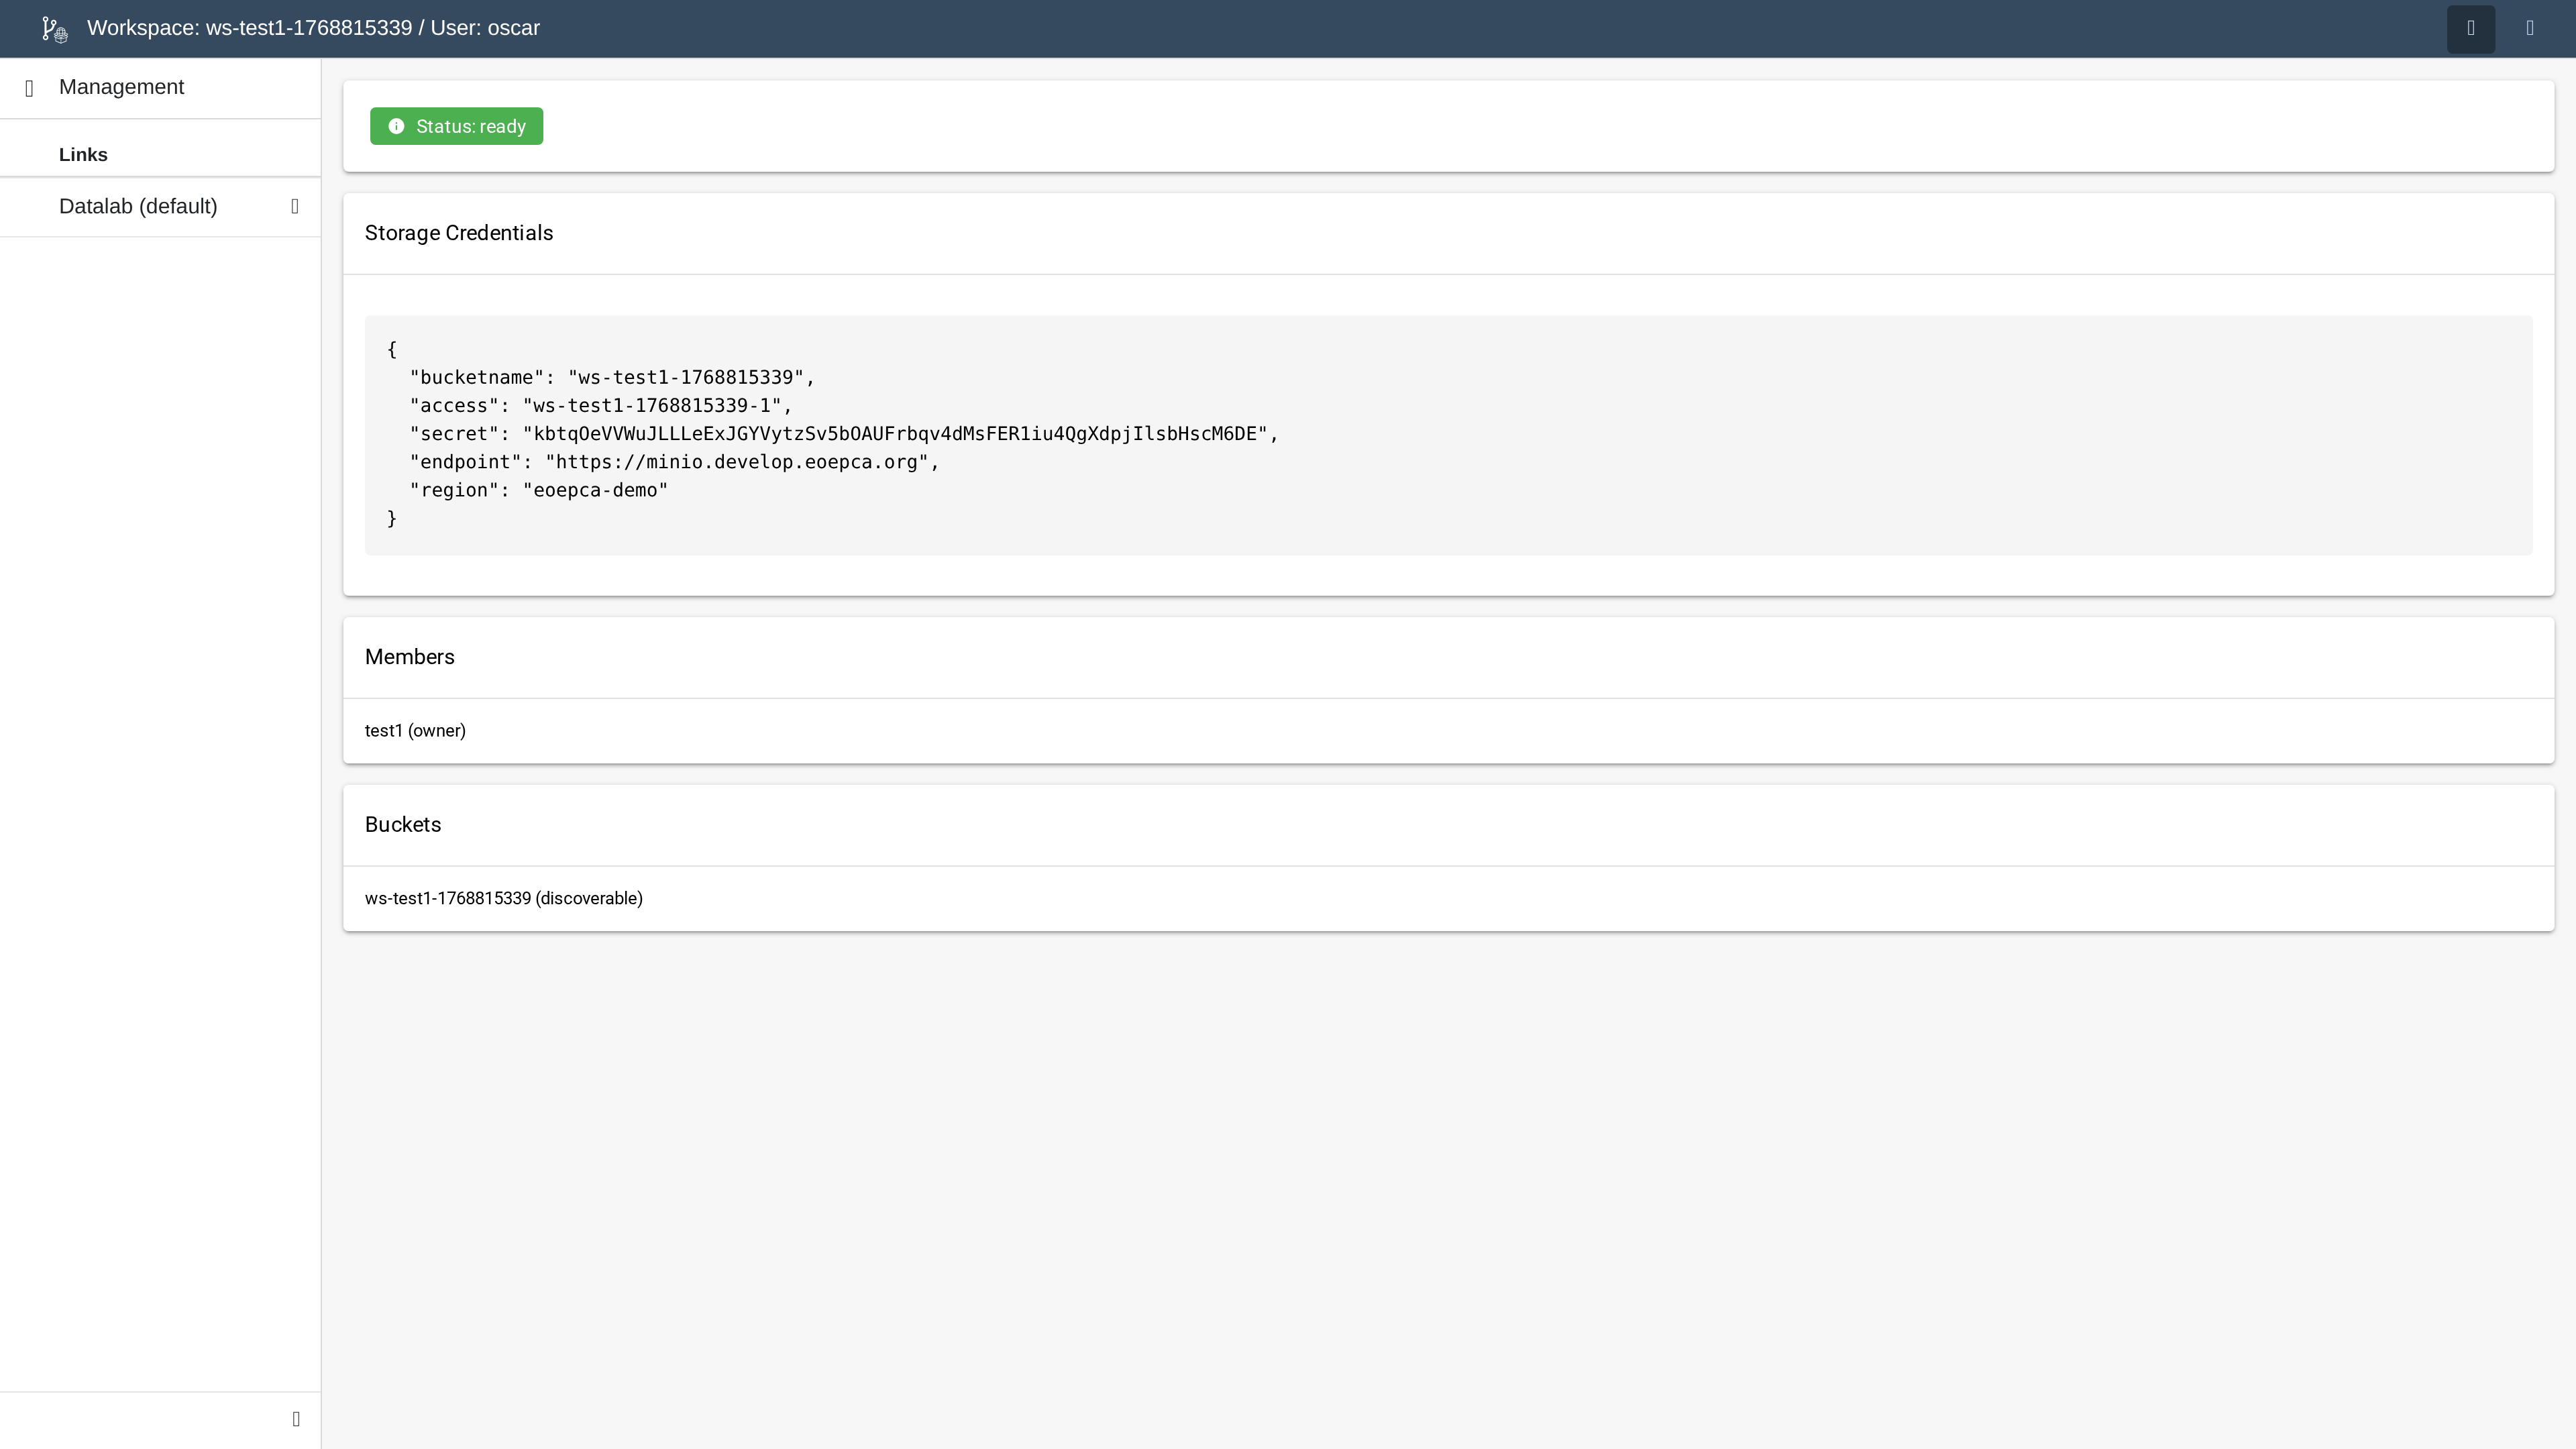

In [9]:
# Dashboard screen
await snap_with_bearer_full(url, token)

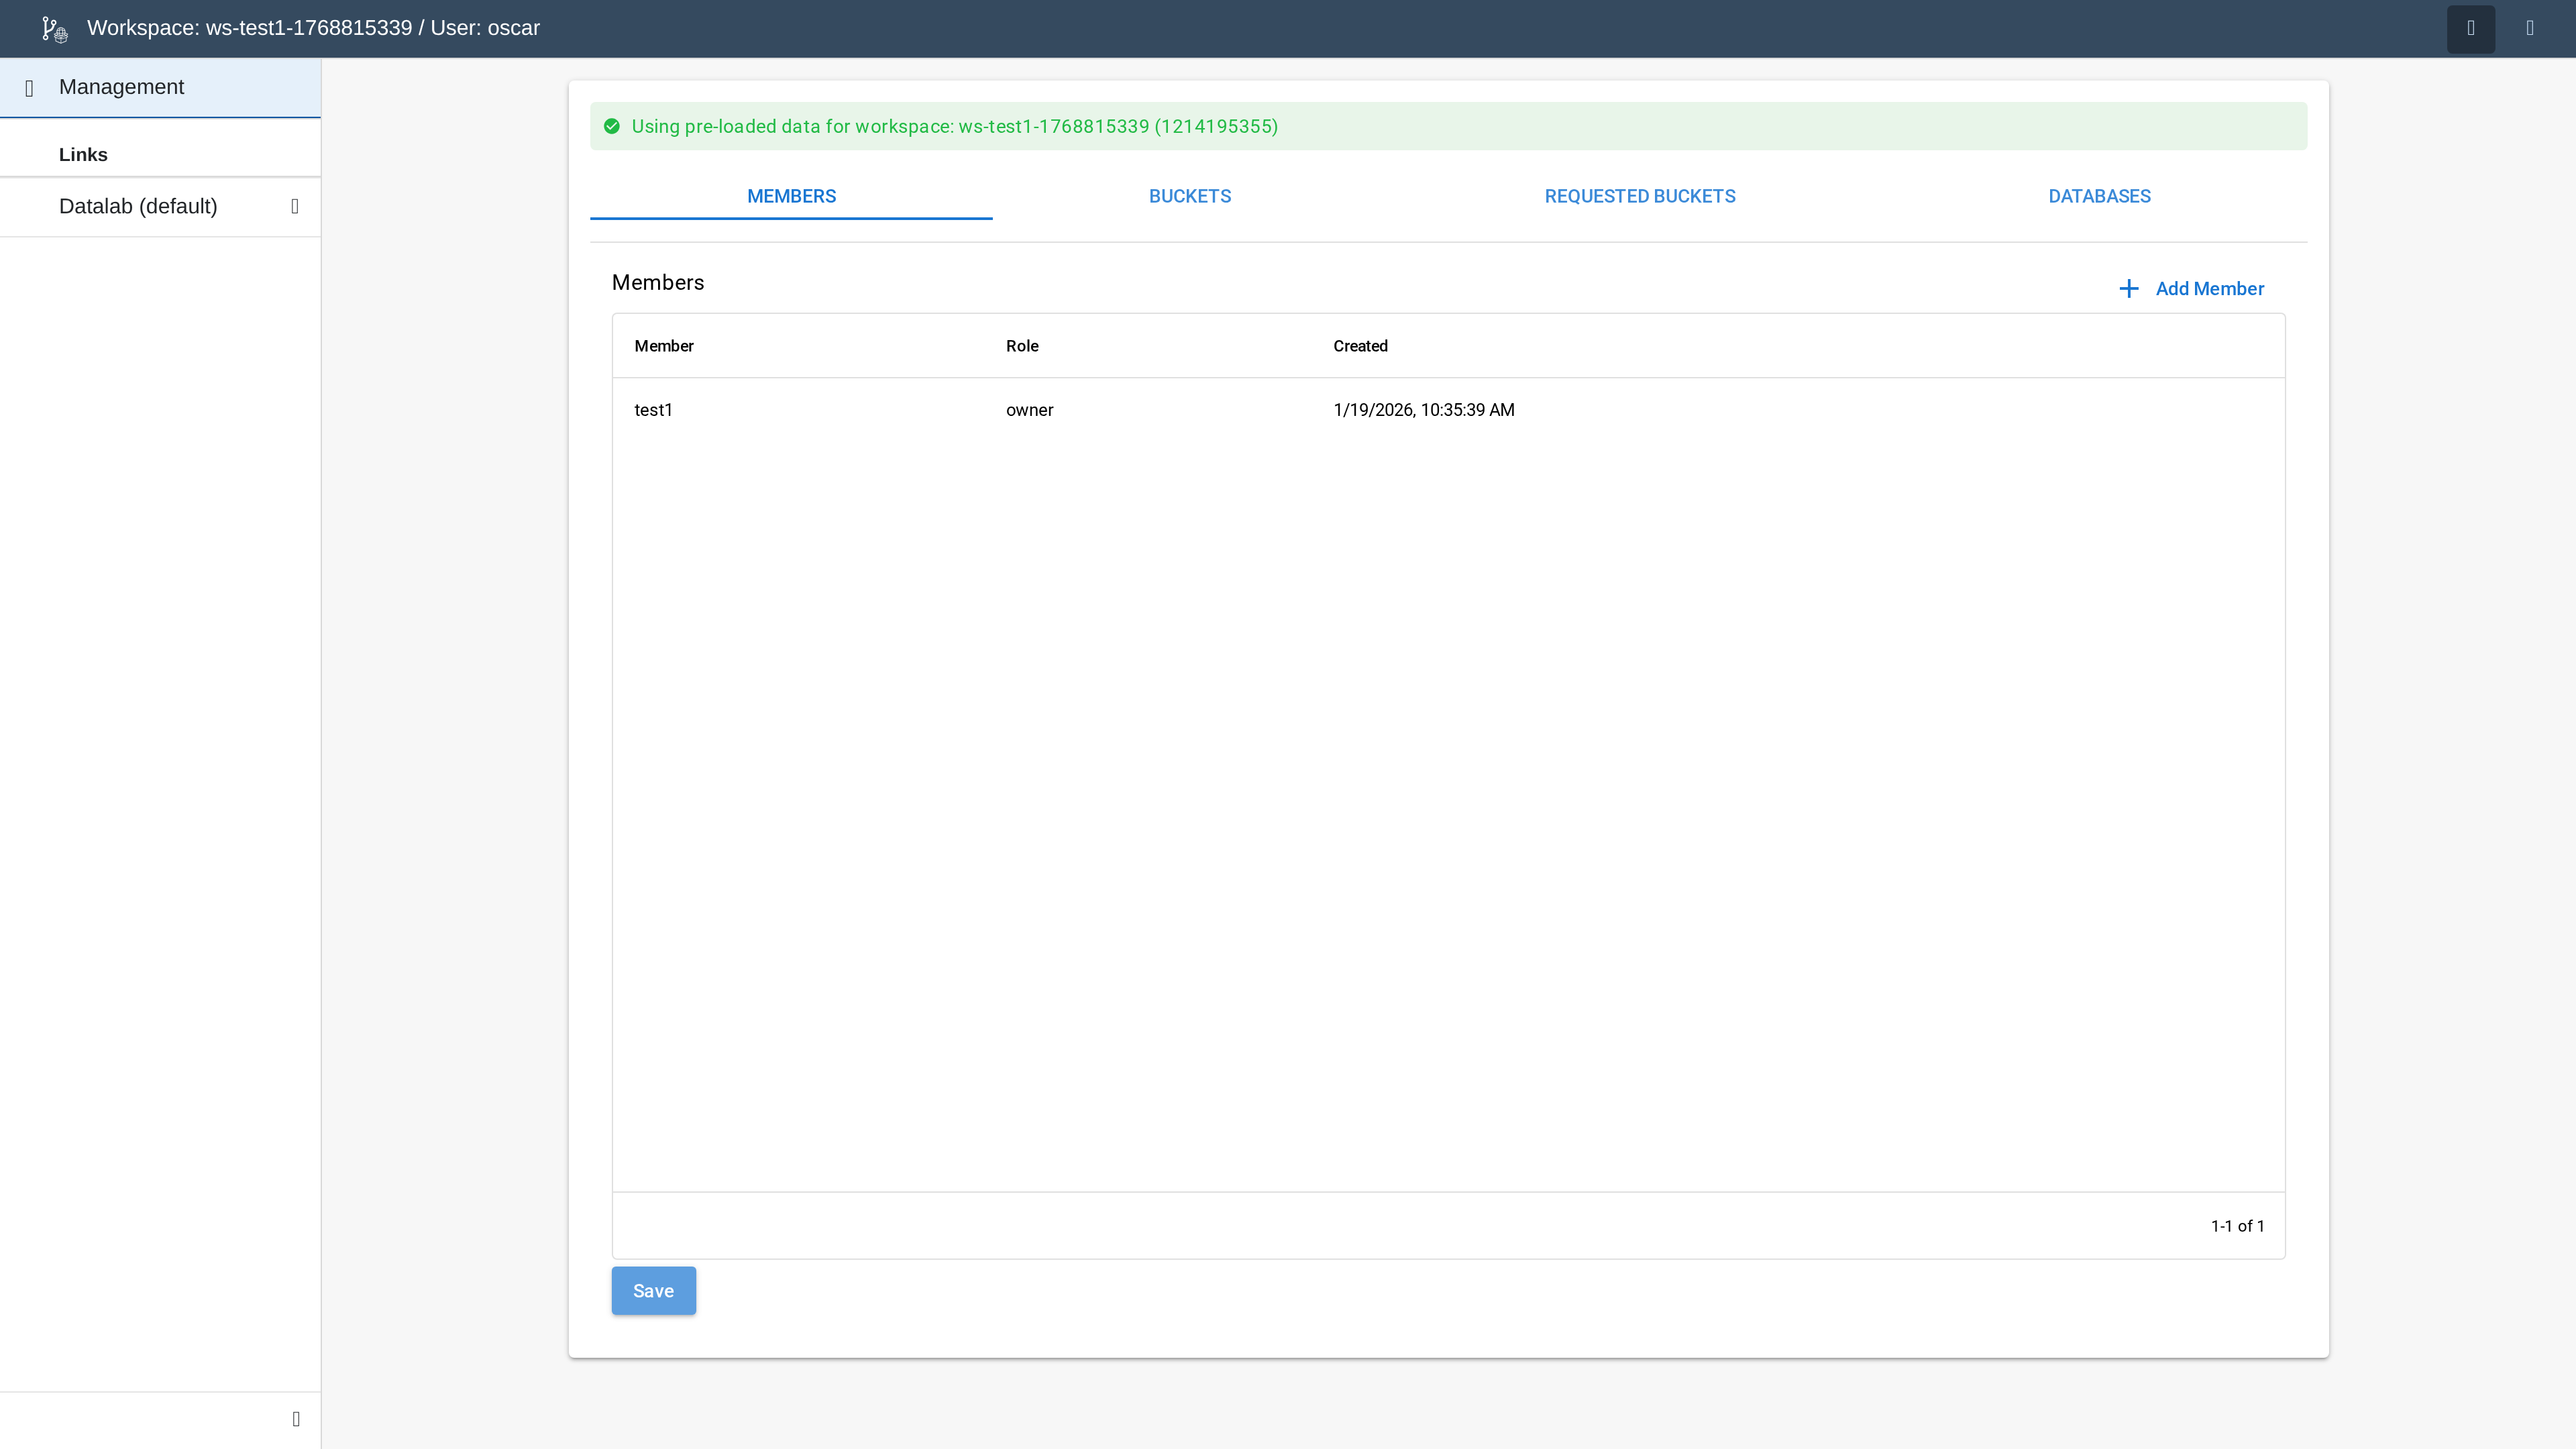

In [10]:
# Management screen
await snap_with_bearer_full(f"{url}#/home/management", token)

In [11]:
# Delete workspace via API
headers = {
    'Authorization': 'bearer ' + token
}
response = requests.delete(
    f"{workspace_api_endpoint}/{ws_name}",
    headers=headers
)
response.raise_for_status()
print(f"deleted workspace '{ws_name}'")

deleted workspace 'ws-test1-1768815339'


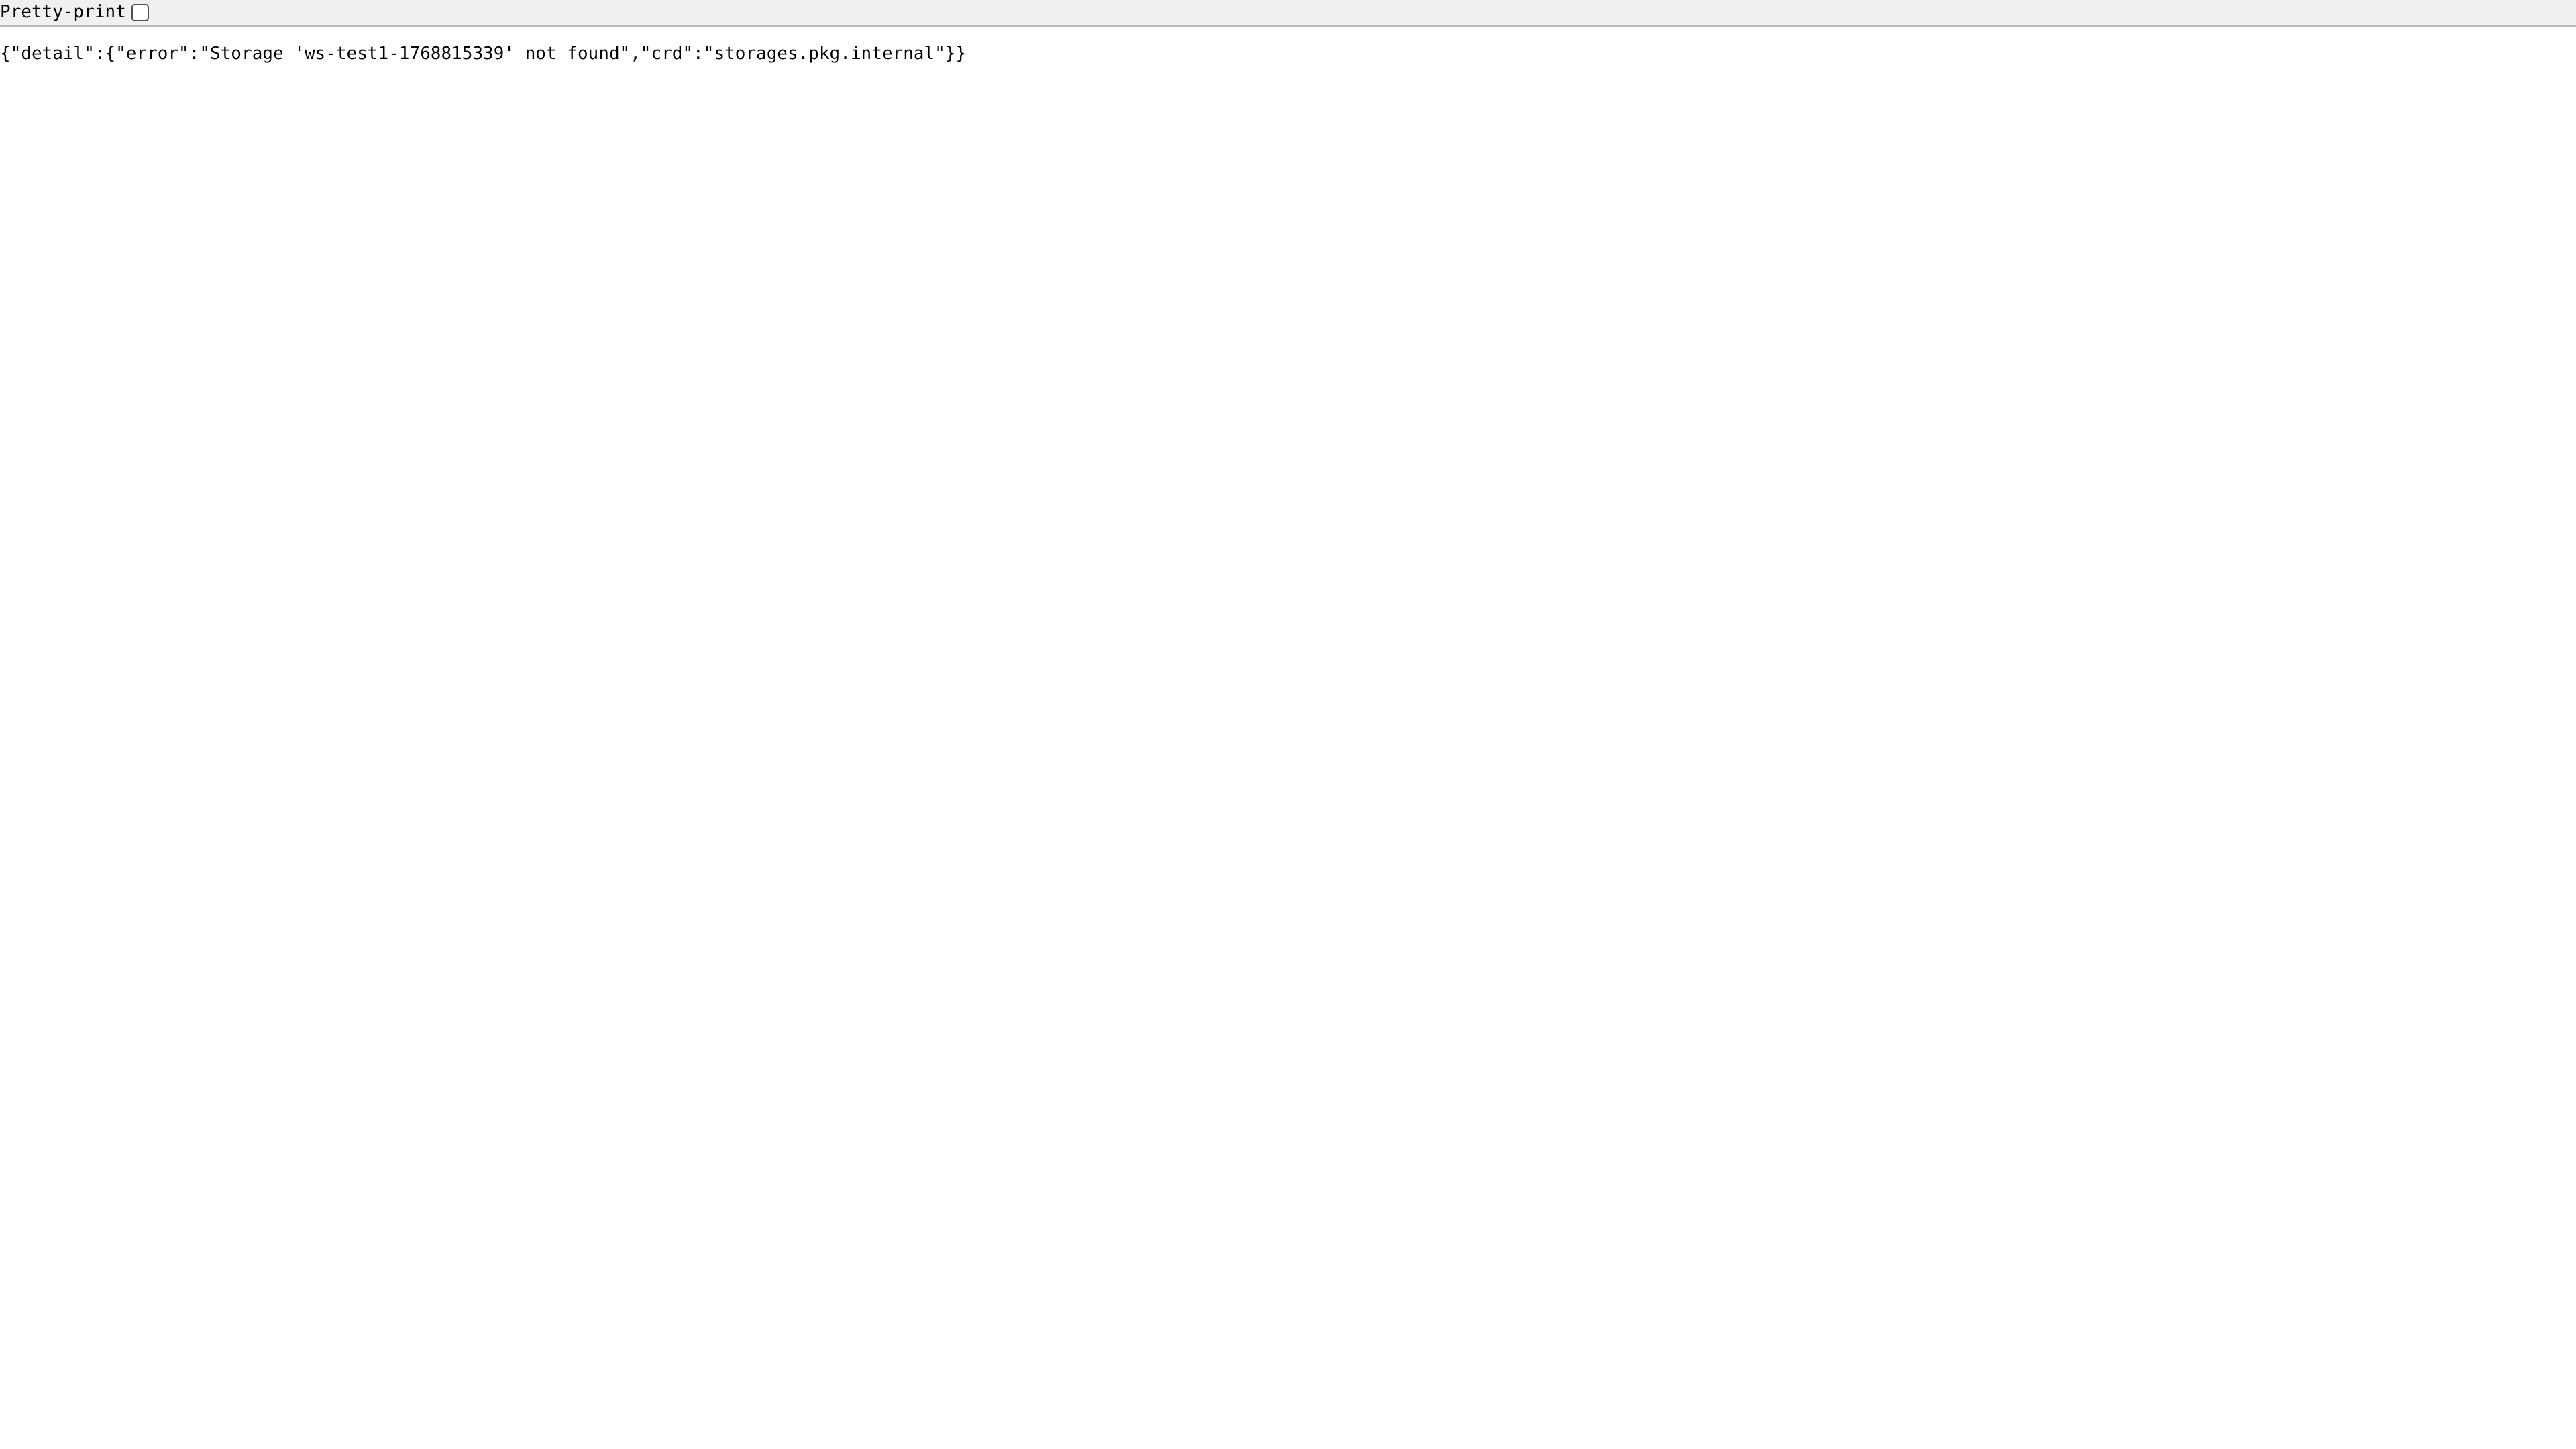

In [12]:
# Verify workspace got delete
await snap_with_bearer_full(f"{url}", token)